In this notebook, takes a first look at using the lookahead PCS in the R&S with the
LCEGP model.

In [1]:
from time import time

import torch
from botorch import fit_gpytorch_model
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils import draw_sobol_normal_samples
from gpytorch import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal

from contextual_rs.lce_gp import LCEGP
from contextual_rs.unknown_correlation_model import UnknownCorrelationModel
from contextual_rs.pcs_no_context import estimate_lookahead_pcs_no_context, estimate_current_pcs_no_context
from contextual_rs.custom_fit import custom_fit_gpytorch_model

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


def model_constructor(model_type: str):
    def model_create(X, Y, custom_fit=0):
        if model_type == "LCEGP":
            model = LCEGP(
                X.view(-1, 1), Y.view(-1, 1), categorical_cols=[0], embs_dim_list=[2]
            )
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            if custom_fit:
                custom_fit_gpytorch_model(mll, num_retries=custom_fit)
            else:
                fit_gpytorch_model(mll)
            return model
        else:
            model = UnknownCorrelationModel(X, Y, update_method=model_type)
            return model
    return model_create


def pcs_run(
    num_alternatives: int,
    rho: float,
    num_full_train: int,
    iterations: int,
    replications: int,
    num_samples: int = 100,
    func_I = lambda X: (X > 0).to(dtype=torch.float),
    num_fantasies: int = 16,
    custom_fit: int = 0,
    device: str = "cpu",
) -> None:
    ckwargs = {"device": device}
    K = num_alternatives
    true_mean = torch.linspace(0, 1, K, **ckwargs)
    true_cov = torch.zeros(K, K, **ckwargs)
    for i in range(K):
        for j in range(K):
            true_cov[i, j] = torch.tensor(rho, **ckwargs).pow(abs(i - j))
    sampling_post = MultivariateNormal(true_mean, true_cov)

    train_X = torch.arange(
        num_alternatives, dtype=torch.float, **ckwargs
    ).repeat(num_full_train)
    train_Y = sampling_post.rsample(torch.Size([num_full_train])).view(-1).detach()

    labels = ["LCEGP", "moment-matching", "KL", "moment-KL"]

    model_constructor_list = [
        model_constructor(m_type) for m_type in labels
    ]

    base_samples = draw_sobol_normal_samples(
        d=num_alternatives, n=num_samples
    ).reshape(num_samples, 1, 1, num_alternatives, 1)
    report_base_samples = base_samples.view(num_samples, num_alternatives, 1)

    all_alternatives = torch.arange(num_alternatives, dtype=torch.float).view(-1, 1, 1)

    predicted_bests = [torch.zeros(replications, iterations) for _ in range(4)]
    current_pcs = torch.zeros(replications, iterations)
    start = time()

    for rep in range(replications):
        X_list = [train_X.clone() for _ in range(4)]
        Y_list = [train_Y.clone() for _ in range(4)]
        for i in range(iterations):
            if i == 0:
                print(f"Starting replication {rep}, iteration {i}, time: {time()-start}")
            next_points = torch.zeros(4)
            for j in range(1):  # running LCEGP only
                constructor = model_constructor_list[j]
                model = constructor(X_list[j], Y_list[j], custom_fit)

                if j:
                    raise NotImplementedError
                    # predicted_bests[j][rep, i] = model.theta.argmax()

                else:
                    predicted_bests[j][rep, i] = model.posterior(all_alternatives).mean.argmax()
                    current_pcs[rep, i] = estimate_current_pcs_no_context(
                        model=model,
                        arm_set=all_alternatives.squeeze(-2),
                        num_samples=num_samples,
                        base_samples=report_base_samples,
                        func_I=func_I
                    )
                    lookahead_pcs_vals = estimate_lookahead_pcs_no_context(
                        candidate=all_alternatives,
                        model=model,
                        model_sampler=SobolQMCNormalSampler(num_fantasies),
                        arm_set=all_alternatives.squeeze(-2),
                        num_samples=num_samples,
                        base_samples=base_samples,
                        func_I=func_I,
                    )
                    next_sample = lookahead_pcs_vals.argmax()

                next_points[j] = next_sample.to(dtype=torch.float)

            full_eval = sampling_post.rsample().view(-1).detach()
            next_evals = full_eval[next_points.long()]

            for j in range(1):  # only LCEGP
                X_list[j] = torch.cat([X_list[j], next_points[j].view(-1)], dim=-1)
                Y_list[j] = torch.cat([Y_list[j], next_evals[j].view(-1)], dim=-1)

    plot_values = [
        sampling_post.mean[tmp.long()].detach().mean(dim=0) for tmp in predicted_bests
    ]
    fig = plt.figure(figsize=(12, 8))
    fig.patch.set_facecolor('xkcd:mint green')

    for i in range(1):  # only LCEGP
        plt.plot(plot_values[i], label=labels[i])
    plt.plot(current_pcs.mean(dim=0), label="pcs estimates")
    plt.axhline(sampling_post.mean.max(), label="true_best")
    plt.grid()
    plt.legend()
    plt.show()


# debug run
# pcs_run(
#     num_alternatives=5,
#     rho=0.5,
#     num_full_train=5,
#     iterations=5,
#     replications=1,
# )


Starting replication 0, iteration 0, time: 3.337860107421875e-05
Starting replication 1, iteration 0, time: 19.047125816345215
Starting replication 2, iteration 0, time: 44.38995337486267
Starting replication 3, iteration 0, time: 64.13124656677246
Starting replication 4, iteration 0, time: 87.11014604568481


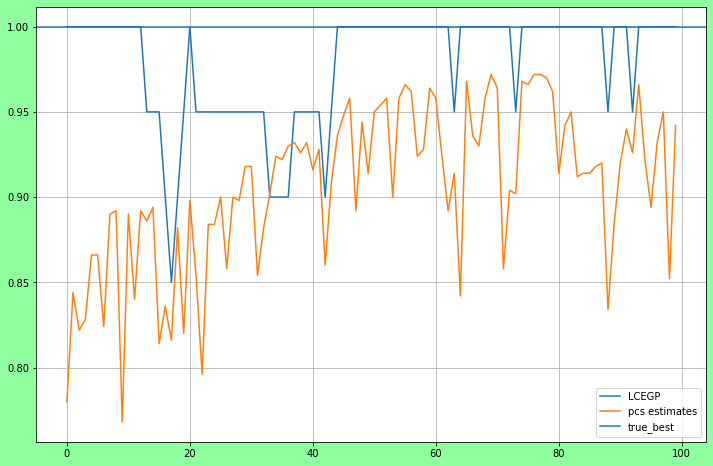

In [2]:
pcs_run(
    num_alternatives=5,
    rho=0.5,
    num_full_train=5,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 4.267692565917969e-05
Starting replication 1, iteration 0, time: 59.61335110664368
Starting replication 2, iteration 0, time: 114.79685139656067
Starting replication 3, iteration 0, time: 169.6978805065155
Starting replication 4, iteration 0, time: 223.59122395515442


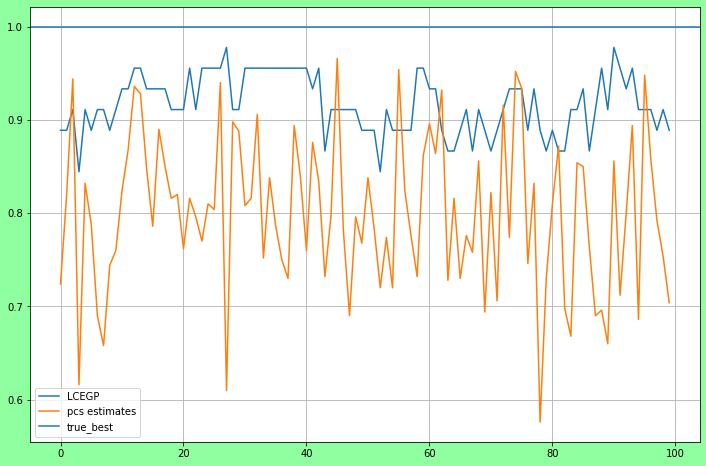

In [3]:
pcs_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=5,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 4.363059997558594e-05
Starting replication 1, iteration 0, time: 35.9311728477478
Starting replication 2, iteration 0, time: 96.52104592323303
Starting replication 3, iteration 0, time: 151.68437504768372
Starting replication 4, iteration 0, time: 211.04477405548096
Starting replication 5, iteration 0, time: 260.50494956970215
Starting replication 6, iteration 0, time: 312.7598555088043
Starting replication 7, iteration 0, time: 366.6131443977356
Starting replication 8, iteration 0, time: 426.9396502971649
Starting replication 9, iteration 0, time: 493.50660276412964


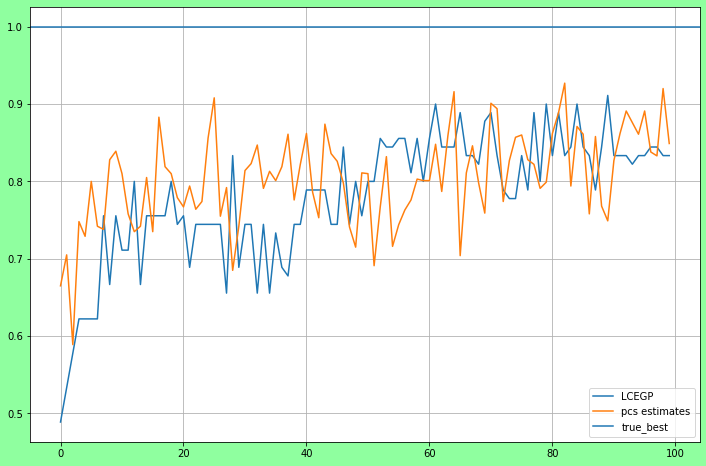

In [4]:
pcs_run(
    num_alternatives=10,
    rho=0.1,
    num_full_train=5,
    iterations=100,
    replications=10,
)

Starting replication 0, iteration 0, time: 3.361701965332031e-05
Starting replication 1, iteration 0, time: 123.65443730354309
Starting replication 2, iteration 0, time: 247.67780351638794
Starting replication 3, iteration 0, time: 384.08615827560425
Starting replication 4, iteration 0, time: 513.1724889278412
Starting replication 5, iteration 0, time: 644.657044172287
Starting replication 6, iteration 0, time: 754.439957857132
Starting replication 7, iteration 0, time: 881.6252791881561
Starting replication 8, iteration 0, time: 1009.9874198436737
Starting replication 9, iteration 0, time: 1122.7651138305664


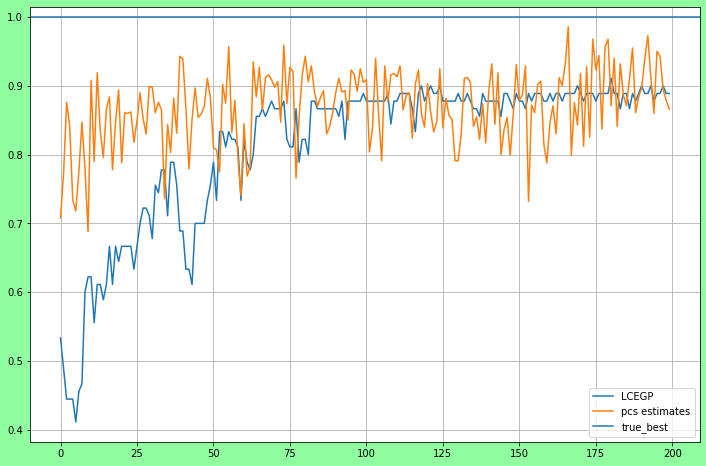

In [5]:
pcs_run(
    num_alternatives=10,
    rho=0.25,
    num_full_train=5,
    iterations=200,
    replications=10,
)

Starting replication 0, iteration 0, time: 3.147125244140625e-05
Starting replication 1, iteration 0, time: 91.15909337997437
Starting replication 2, iteration 0, time: 179.03404331207275
Starting replication 3, iteration 0, time: 266.34378957748413
Starting replication 4, iteration 0, time: 350.4905655384064


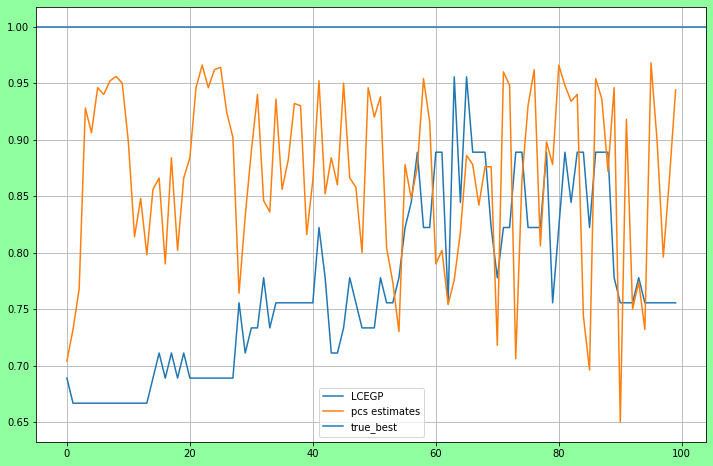

In [8]:
pcs_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=5,
    iterations=100,
    replications=5,
    custom_fit=3,
)

In [9]:
pcs_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=5,
    iterations=100,
    replications=5,
    custom_fit=10,
)

Starting replication 0, iteration 0, time: 3.314018249511719e-05


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(52,52) is zero, singular U.